In [10]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

### Konvoliucijos paaiškinimas

Įprastai atliekant konvoliuciją su dvimačiais paveikslėliais, kiekvienas pikselių kvadratas yra dauginamas iš to paties filtro.

**Paveikslėlio pavyzdys**

    >>> N = np.random.randint(5, size=(4, 5))
    >>> print(N)
    [[0 1 1 2 3]
     [0 1 2 1 2]
     [3 4 2 0 2]
     [3 4 4 1 2]]
     
**Dauginami elementai**

    >>> W = sliding_window_view(N, (3, 3))
    >>> print(W)
    [[[[0 1 1]
       [0 1 2]
       [3 4 2]]

      [[1 1 2]
       [1 2 1]
       [4 2 0]]

      [[1 2 3]
       [2 1 2]
       [2 0 2]]]


     [[[0 1 2]
       [3 4 2]
       [3 4 4]]

      [[1 2 1]
       [4 2 0]
       [4 4 1]]

      [[2 1 2]
       [2 0 2]
       [4 1 2]]]]
       
**Filtro pavyzdys**

    >>> F = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    >>> print(F)
    [[ 0 -1  0]
     [-1  5 -1]
     [ 0 -1  0]]
   
**Dauginimo panariui rezultatas**

    >>> print(W * F[None, None, ...])
    [[[[ 0 -1  0]
       [ 0  5 -2]
       [ 0 -4  0]]

      [[ 0 -1  0]
       [-1 10 -1]
       [ 0 -2  0]]

      [[ 0 -2  0]
       [-2  5 -2]
       [ 0  0  0]]]


     [[[ 0 -1  0]
       [-3 20 -2]
       [ 0 -4  0]]

      [[ 0 -2  0]
       [-4 10  0]
       [ 0 -4  0]]

      [[ 0 -1  0]
       [-2  0 -2]
       [ 0 -1  0]]]]
       
**Konvoliucijos rezultatas**

    >>> print(np.sum(W * F[None, None, ...], axis=(2, 3)))
    [[-2  5 -1]
     [10  0 -6]]
 
Skirtingo filtravimo pavyzdžius galite peržiūrėti [šioje nuorodoje](https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details)

### Bendras filtras

Šiuo atveju galima sudėti šias dauginimo matricas:

    | 0 -1  0  0  0|   | 0  0 -1  0  0|   | 0  0  0 -1  0|   | 0  0  0  0  0|   | 0  0  0  0  0|   | 0  0  0  0  0|
    |-1  5 -1  0  0|   | 0 -1  5 -1  0|   | 0  0 -1  5 -1|   | 0 -1  0  0  0|   | 0  0 -1  0  0|   | 0  0  0 -1  0|
    | 0 -1  0  0  0|   | 0  0 -1  0  0|   | 0  0  0 -1  0|   |-1  5 -1  0  0|   | 0 -1  5 -1  0|   | 0  0 -1  5 -1| 
    | 0  0  0  0  0|   | 0  0  0  0  0|   | 0  0  0  0  0|   | 0 -1  0  0  0|   | 0  0 -1  0  0|   | 0  0  0 -1  0|

Ir gauti bendrą filtrą:

    >>> BF = np.array([[0, -1, -1, -1, 0], [-1, 3, 2, 3, -1], [-1, 3, 2, 3, -1], [0, -1, -1, -1, 0]])
    >>> print(BF)
    [[ 0 -1 -1 -1  0]
     [-1  3  2  3 -1]
     [-1  3  2  3 -1]
     [ 0 -1 -1 -1  0]]

Tam buvo galima naudoti tokį metodą:
    
    def kernel_sum(image_shape, kernel):
        M = np.zeros(image_shape, int)
        A = np.lib.stride_tricks.sliding_window_view(M, kernel.shape)
        x, y, z, t = np.indices(A.shape)
        np.add.at(A, (x,y,z,t), kernel[None, None, ...])
        return M
    
    >>> kernel_sum(image_shape=(4, 5), kernel=np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    array([[ 0, -1, -1, -1,  0],
           [-1,  3,  2,  3, -1],
           [-1,  3,  2,  3, -1],
           [ 0, -1, -1, -1,  0]])

Parašykite panašų metodą, kuris gali sudėti pikselius bet kuriam pateiktam skirtingų filtrų sąrašui.

[Source of discussion](https://stackoverflow.com/questions/70726136/)

### Input
    L = np.array([[[[ 1, 2], [ 3, 4]], [[ 5, 6], [ 7, 8]]], 
                  [[[ 9,10], [11,12]], [[13,14], [15,16]]],
                  [[[17,18], [19,20]], [[21,22], [23,24]]]])

### Expected output
    array([[ 1,  7,  6],
           [12, 34, 22],
           [28, 66, 38],
           [19, 43, 24]])

### Sprendimai
**Sprendimas 1**

In [193]:
def kernel_array_sum(kernel_array, dtype=int):
    N, k = np.array(kernel_array.shape[:2]), np.array(kernel_array.shape[2:])
    M = np.zeros(N + k - 1, dtype=dtype)
    A = np.lib.stride_tricks.sliding_window_view(M, k)
    x, y, z, t = np.indices(A.shape)
    np.add.at(A, (x,y,z,t), kernel_array)
    return M

kernel_array_sum(L)

array([[ 1,  7,  6],
       [12, 34, 22],
       [28, 66, 38],
       [19, 43, 24]])

**Sprendimas 2**

In [257]:
from numba import njit, prange

L = np.array([[[[ 1, 2], [ 3, 4]], [[ 5, 6], [ 7, 8]]], 
              [[[ 9,10], [11,12]], [[13,14], [15,16]]],
              [[[17,18], [19,20]], [[21,22], [23,24]]]])

@njit(fastmath=True)
def _nkas_f(M, L, s1, s2):
    for i in prange(s1):
        for j in range(s2):
            M[i:i+k[0], j:j+k[1]] += L[i][j]
            
def numba_kernel_array_sum_f(kernel_array):
    N, k = np.array(kernel_array.shape[:2]), np.array(kernel_array.shape[2:])
    M = np.zeros(N + k - 1, dtype=int)
    _nkas_f(M, kernel_array, *kernel_array.shape[:2])
    return M

numba_kernel_array_sum(L)

array([[ 1,  7,  6],
       [12, 34, 22],
       [28, 66, 38],
       [19, 43, 24]])

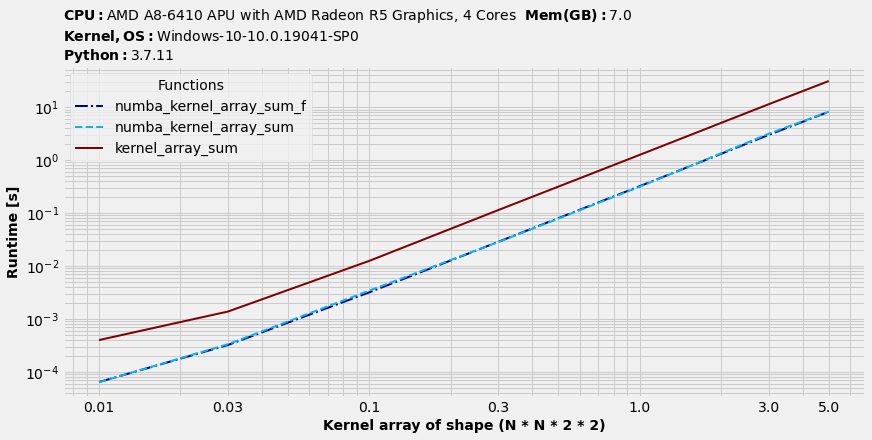

In [256]:
import benchit
%matplotlib inline
benchit.setparams(rep=3)

#without fastmath option
@njit
def _nkas(M, L):
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            M[i:i+k[0], j:j+k[1]] += L[i][j]
            
def numba_kernel_array_sum(kernel_array):
    N, k = np.array(kernel_array.shape[:2]), np.array(kernel_array.shape[2:])
    M = np.zeros(N + k - 1, dtype=int)
    _nkas(M, kernel_array)
    return M

numba_kernel_array_sum(L)

sizes = [10, 30, 100, 300, 1000, 3000, 5000]
N = sizes[-1]
arr = np.random.randint(100, size=(N, N, 2, 2), dtype=int)
fns = [numba_kernel_array_sum_f, numba_kernel_array_sum, kernel_array_sum]

in_ = {s/1000: (arr[:s, :s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Kernel array of shape (N * N * 2 * 2)')
t.plot(logx=True, figsize=(12, 6), fontsize=14)